<a href="https://colab.research.google.com/github/Daviey52/try/blob/main/Assignment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
import numpy as np
import tensorflow as tf
import sys
import csv
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)


In [151]:
df = pd.read_csv('/content/MSFT.csv')
print(df)


            Date        Open        High         Low       Close   Adj Close  \
0      11/7/2016   59.779999   60.520000   59.779999   60.419998   55.902321   
1      11/8/2016   60.549999   60.779999   60.150002   60.470001   55.948589   
2      11/9/2016   60.000000   60.590000   59.200001   60.169998   55.671009   
3     11/10/2016   60.480000   60.490002   57.630001   58.700001   54.310928   
4     11/11/2016   58.230000   59.119999   58.009998   59.020000   54.607002   
...          ...         ...         ...         ...         ...         ...   
1254   11/1/2021  331.359985  331.489990  326.369995  329.369995  329.369995   
1255   11/2/2021  330.309998  333.450012  330.000000  333.130005  333.130005   
1256   11/3/2021  333.899994  334.899994  330.649994  334.000000  334.000000   
1257   11/4/2021  332.890015  336.540009  329.510010  336.440002  336.440002   
1258   11/5/2021  338.510010  338.790009  334.420013  336.059998  336.059998   

        Volume  
0     31664800  
1    

## Preprocessing

1.   Parse the Date Column and sort by Date
2.   Drop the Adj Close column
3.   Normalize numerica features(Open, High, Low, Close, Volume)




In [152]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by="Date", ascending=True, inplace=True)
print(df['Date'].is_monotonic_increasing)
df2 = df.drop(columns='Adj Close',)

exclude = ["Date"]
cols_to_scale = [c for c in df2.columns[1:] if c not in exclude]
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df2[cols_to_scale])

df_scaled = df2.copy()
df_scaled[cols_to_scale] = scaled_df
print (df_scaled.iloc[1:])



True
           Date      Open      High       Low     Close    Volume
1    2016-11-08  0.008277  0.006078  0.010356  0.008444  0.149396
2    2016-11-09  0.006315  0.005398  0.006928  0.007366  0.406553
3    2016-11-10  0.008028  0.005041  0.001263  0.002084  0.485441
4    2016-11-11  0.000000  0.000143  0.002634  0.003234  0.301900
5    2016-11-14  0.002819  0.000000  0.000000  0.000000  0.326565
...         ...       ...       ...       ...       ...       ...
1254 2021-11-01  0.974490  0.973901  0.970953  0.974598  0.189253
1255 2021-11-02  0.970744  0.980909  0.984051  0.988107  0.183608
1256 2021-11-03  0.983552  0.986093  0.986397  0.991233  0.135571
1257 2021-11-04  0.979949  0.991956  0.982283  1.000000  0.159576
1258 2021-11-05  1.000000  1.000000  1.000000  0.998635  0.145819

[1258 rows x 6 columns]


## Windowing


1.   Use a sliding window of N(20) days to predict next day's value
2.   Shape the input as (Sample, timesteps, features)



In [153]:
def sliding_window(df, features_cols,  window_size):
  X = []
  y = []

  features = df[features_cols].values

  for i in range (window_size, len(df)):
    X.append(features[i-window_size:i,:])
    y.append(features[i,:])
  return np.array(X), np.array(y)



In [154]:
window_size = 20
features_cols = ["Open", "High", "Low", "Close", "Volume"]


X, y = sliding_window(df_scaled, features_cols, window_size)

In [155]:
X.shape

(1239, 20, 5)

In [156]:
y.shape

(1239, 5)

In [157]:
train_idx = int(len(X) * 0.9)

X_train = X[:train_idx]
y_train = y[:train_idx]

X_val = X[train_idx:]
y_val = y[train_idx:]



## Modeling
### Build and train 3 different RNN models:


1.   Simple RNN
2.   GRU
3.   LSTM

All models should output 5 values(Open, High, Low , Close, Volume)



### SimpleRNN model

In [158]:
from tensorflow import keras

In [159]:
np.random.seed(42)
tf.random.set_seed(42)
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 5]),
    keras.layers.SimpleRNN(20,),
    keras.layers.Dense(5)
])
model.compile(loss="mse", optimizer=keras.optimizers.Adam(0.001))
model.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),callbacks=[early_stopping]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_10 (SimpleRNN)       │ (None, None, 20)       │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_11 (SimpleRNN)       │ (None, 20)             │           820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,445 (5.64 KB)

 Trainable params: 1,445 (5.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.2921 - val_loss: 0.1901
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0383 - val_loss: 0.1082
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0175 - val_loss: 0.0703
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0109 - val_loss: 0.0532
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0075 - val_loss: 0.0429
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0056 - val_loss: 0.0359
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0044 - val_loss: 0.0309
Epoch 8/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0037 - val_loss: 0.0273
Epoch 9/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - val_loss: 0.0245
Epoch 10/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 0.0223
Epoch 11/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0027 - val_loss: 0.0205
Epoch 12/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0

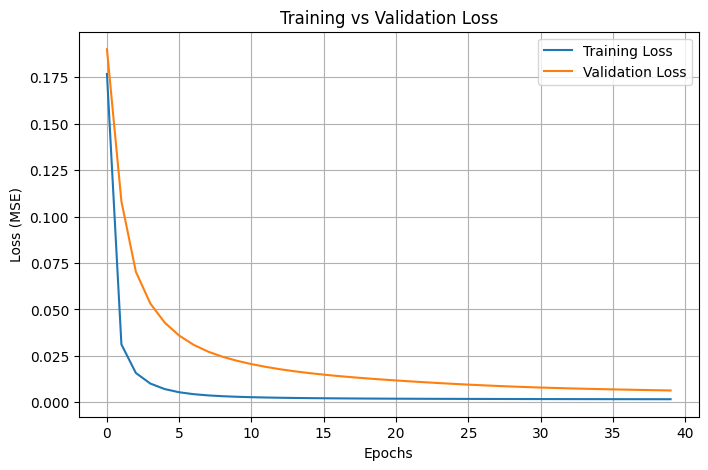

In [160]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### GRU model

In [161]:
np.random.seed(42)
tf.random.set_seed(42)
model2 = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 5]),
    keras.layers.GRU(20),
    keras.layers.Dense(5)
])
model2.compile(loss="mse", optimizer=keras.optimizers.Adam(0.001))
model2.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history2 = model2.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),callbacks=[early_stopping]
)

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_10 (GRU)                    │ (None, None, 20)       │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_11 (GRU)                    │ (None, 20)             │         2,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,245 (16.58 KB)

 Trainable params: 4,245 (16.58 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0432 - val_loss: 0.0624
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0074 - val_loss: 0.0212
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0018 - val_loss: 0.0047
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 8/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 9/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 10/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 11/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 12/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

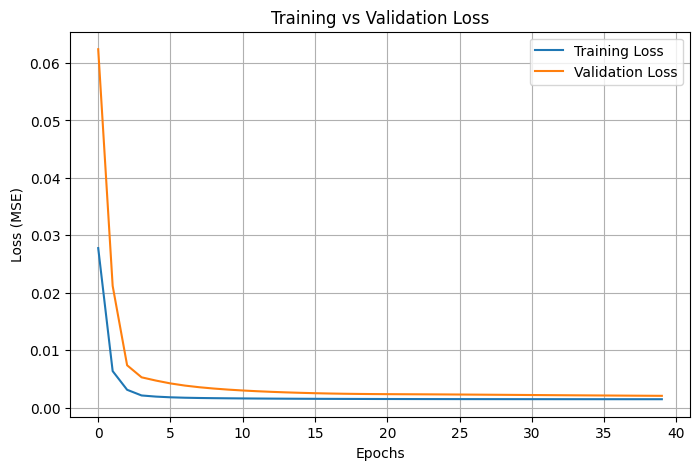

In [162]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history2.history["loss"], label="Training Loss")
plt.plot(history2.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## LSMT Model

In [163]:
np.random.seed(42)
tf.random.set_seed(42)
model3 = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 5]),
    keras.layers.LSTM(20 ),
    keras.layers.Dense(5)
])
model3.compile(loss="mse", optimizer=keras.optimizers.Adam(0.001))
model3.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
history3 = model3.fit(
    X_train, y_train,
    epochs=40,
    batch_size=32,
    validation_data=(X_val, y_val),callbacks=[early_stopping]
)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, None, 20)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,465 (21.35 KB)

 Trainable params: 5,465 (21.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0513 - val_loss: 0.0316
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0045 - val_loss: 0.0084
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0025 - val_loss: 0.0075
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0022 - val_loss: 0.0075
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0021 - val_loss: 0.0069
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 0.0064
Epoch 8/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0020 - val_loss: 0.0058
Epoch 9/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 10/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 11/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0020 - val_loss: 0.0043
Epoch 12/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0

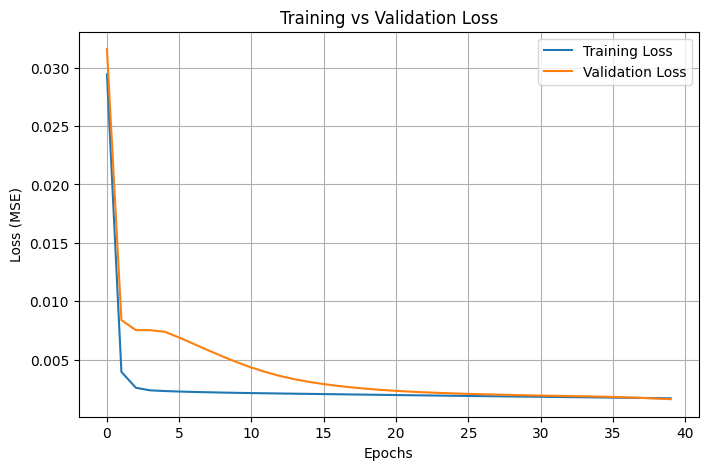

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history3.history["loss"], label="Training Loss")
plt.plot(history3.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

## Evaluation


1.   Predict all the 5 column for the 10 business days between 11/08/2021 and 11/19/2021
2.   Evaluate the prediction using MSE or MAE for each feature
3.   Plot predicted vs true value for each column



### Simple RNN

#### 10 days predictions


In [165]:
def predict_future_days(model, df_scaled, features_cols, window_size, n_days):
  window = df_scaled[features_cols].values[-window_size:]

  predictions = []

  for i in range(n_days):
    X_input = window.reshape(1,window_size, len(features_cols))

    pred = model.predict(X_input)
    predictions.append(pred[0])

    window = np.vstack([window[1:],pred[0]])

  return np.array(predictions)

In [166]:
columns = ["Open", "High", "Low", "Close", "Volume"]
future_scaled_Srnn = predict_future_days(model,df_scaled,columns,window_size=20,n_days=10)
future_Srnn = scaler.inverse_transform(future_scaled_Srnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


#### SimpleRNN predicted data

In [167]:
simpleRNN_predTable =pd.DataFrame(future_Srnn, columns=columns)
print(simpleRNN_predTable)

         Open        High         Low       Close      Volume
0  283.138885  283.529114  289.672729  293.642731  19862556.0
1  282.495361  281.552307  277.138275  278.764038  27735900.0
2  273.412933  274.796570  268.711670  269.114471  32622016.0
3  264.074615  257.459473  254.823776  263.953186  35037760.0
4  256.992706  257.298096  250.715271  256.038177  35122796.0
5  250.108429  252.270096  246.398712  249.947128  34805372.0
6  246.526566  248.086716  241.511215  247.786484  35158440.0
7  242.666351  244.032059  238.477631  245.176987  35562744.0
8  239.979584  240.497040  236.475494  240.909546  34793168.0
9  237.985992  238.895081  234.646164  238.224121  34152304.0


In [168]:
df_true_values = pd.read_csv('/content/MSFT_predicted.csv')

df_true_values['Date'] = pd.to_datetime(df['Date'])
df_true_values.sort_values(by="Date", ascending=True, inplace=True)
print(df_true_values['Date'].is_monotonic_increasing)
true_10 = df_true_values[columns].values
true_10.shape




True


(10, 5)

### Simple RNN MSE calulation

In [169]:
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = {}
for i, col in enumerate (["Open","High","Low","Close","Volume"]):
  mae[col] = mean_absolute_error(true_10[:, i], future_Srnn[:, i])

print("MAE per feature:")
for k, v in mae.items():
    print(f"{k}: {v:.4f}")

MAE per feature:
Open: 78.8359
High: 83.8683
Low: 80.8309
Close: 78.7743
Volume: 11585924.4000


### Simple RNN Plot predicted VS True

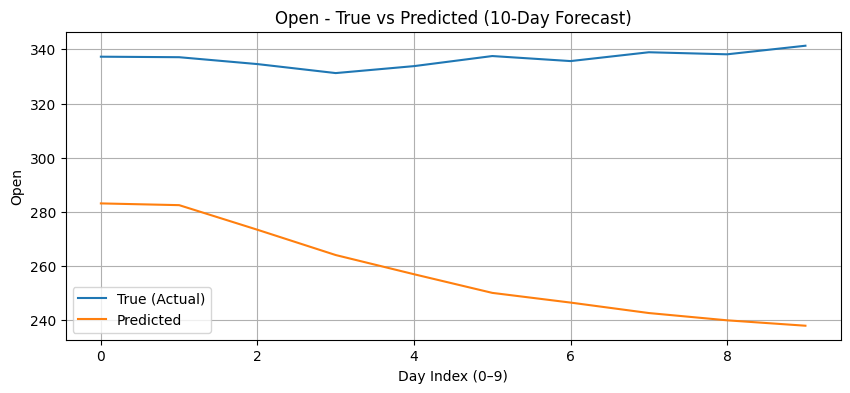

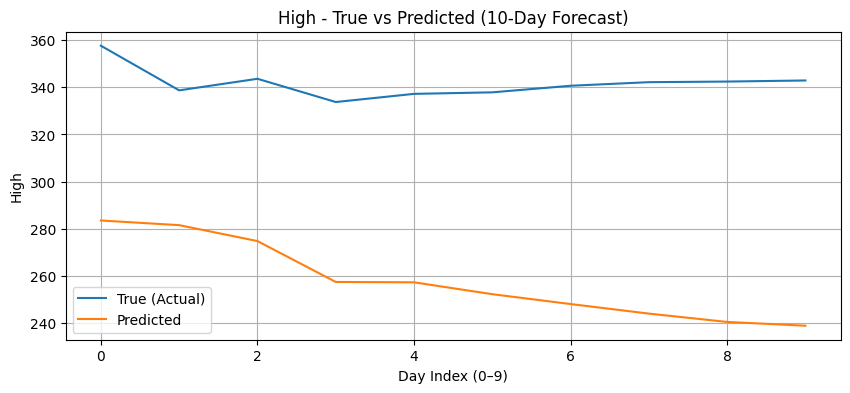

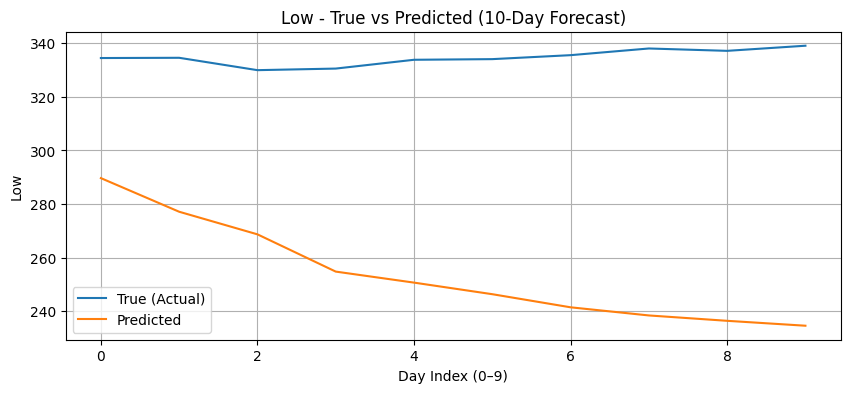

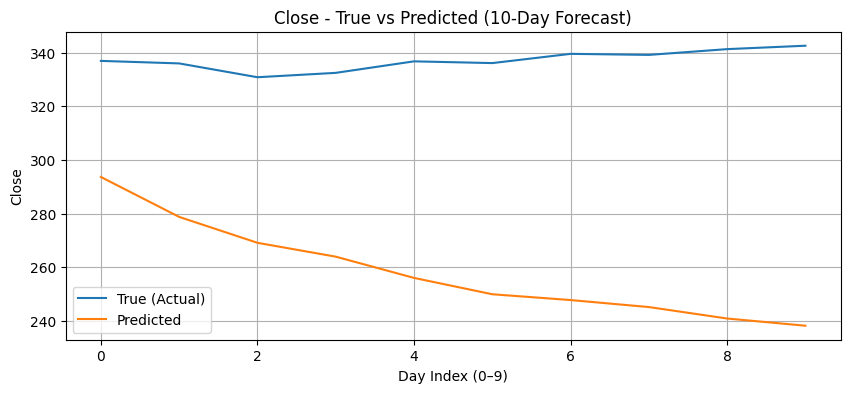

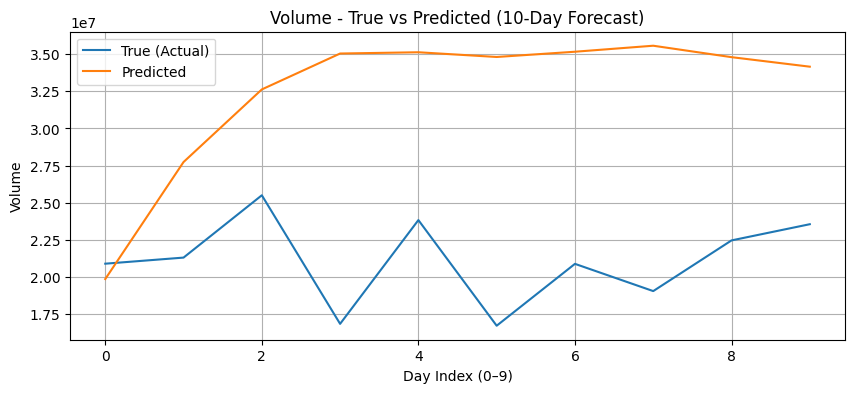

In [170]:
import matplotlib.pyplot as plt

for i, col in enumerate(columns):
    plt.figure(figsize=(10,4))
    plt.plot(true_10[:, i], label="True (Actual)")
    plt.plot(future_Srnn[:, i], label="Predicted")
    plt.title(f"{col} - True vs Predicted (10-Day Forecast)")
    plt.xlabel("Day Index (0–9)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()

### GRU
#### 10 days predictions

In [171]:
future_scaled_GRU = predict_future_days(model2, df_scaled, columns, window_size=20, n_days=10)
future_GRU_pred = scaler.inverse_transform(future_scaled_GRU)
GRU_predTable = pd.DataFrame(future_GRU_pred, columns=columns)
print(GRU_predTable)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
         Open        High         Low       Close      Volume
0  310.163086  311.561096  310.207794  315.750977  22190130.0
1  304.470520  302.568207  301.545380  303.562561  22203844.0
2  299.314514  295.072968  294.312805  295.396545  21393172.0
3  293.929932  289.010162  288.824982  289.529114  21003928.0
4  289.029114  284.018188  284.259277  285.001129  21026578.0
5  284.719025  279.898529  280.238800  281.178131  21257794.0
6  280.893280  276.439270  276.638306  277.779541  21564334.0
7  277.477600  273.466309  273.391724  274.708649  21889174.0
8  274.390778  270.858551  270.444885  271.917908  22206

MSE Calulations

In [172]:
mae = {}
for i, col in enumerate (["Open","High","Low","Close","Volume"]):
  mae[col] = mean_absolute_error(true_10[:, i], future_GRU_pred[:, i])

print("MAE per feature:")
for k, v in mae.items():
    print(f"{k}: {v:.4f}")


MAE per feature:
Open: 47.9767
High: 56.5675
Low: 49.9255
Close: 50.7100
Volume: 2260766.2000


GRU plot predicted VS True

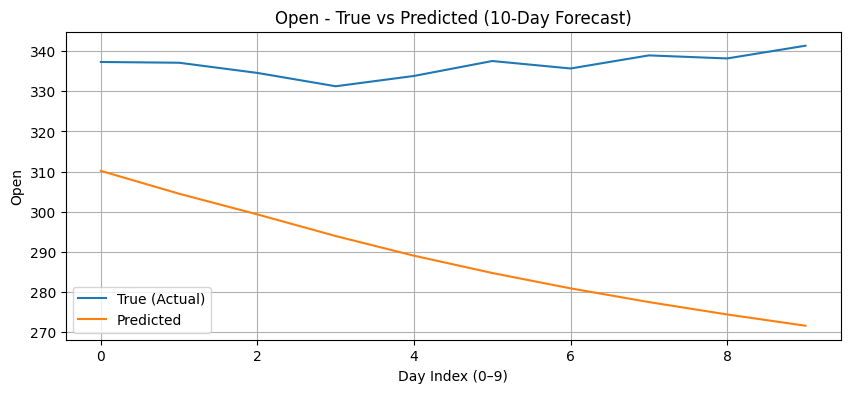

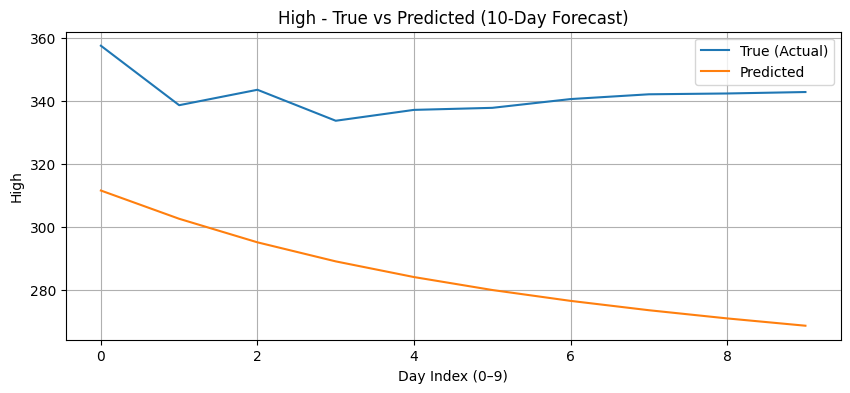

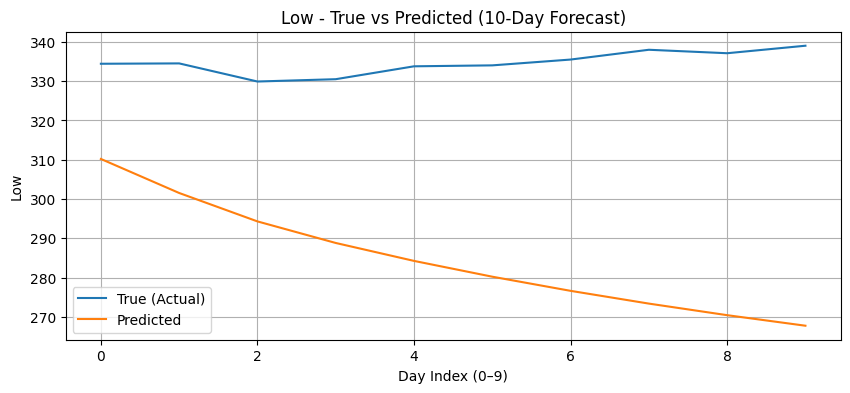

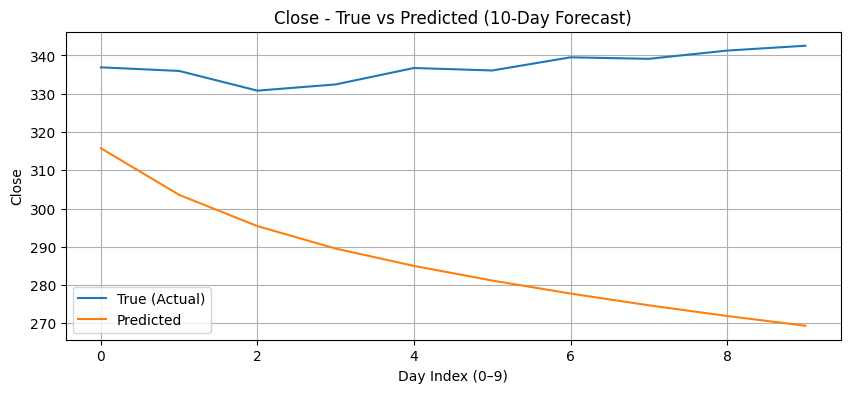

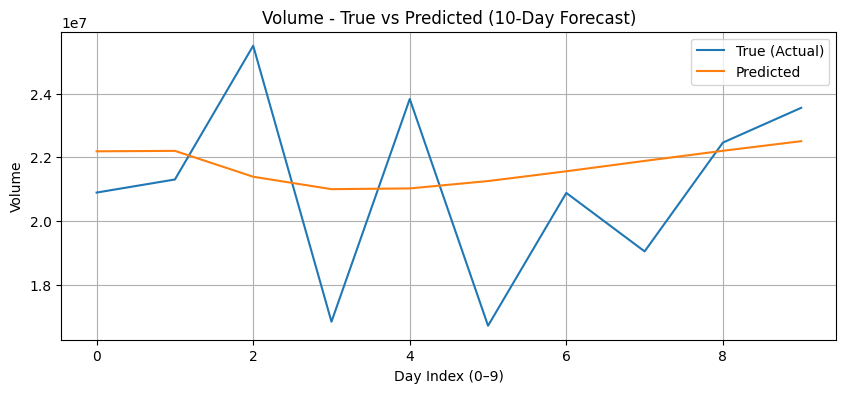

In [173]:
for i, col in enumerate(columns):
    plt.figure(figsize=(10,4))
    plt.plot(true_10[:, i], label="True (Actual)")
    plt.plot(future_GRU_pred[:, i], label="Predicted")
    plt.title(f"{col} - True vs Predicted (10-Day Forecast)")
    plt.xlabel("Day Index (0–9)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()


### LSTM


### 10 days prediction

In [174]:
future_scaled_LSTM = predict_future_days(model3, df_scaled,columns, window_size=20, n_days=10)
future_LSTM_pred = scaler.inverse_transform(future_scaled_LSTM)
LSTM_predTable = pd.DataFrame(future_LSTM_pred, columns=columns)
print(LSTM_predTable)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
         Open        High         Low       Close      Volume
0  314.175476  311.386841  318.704041  318.288544  21159032.0
1  313.813629  311.692322  318.232880  318.701050  21733080.0
2  312.826050  311.641174  317.802856  318.414764  22150842.0
3  311.615540  311.272400  317.158386  317.560211  22425526.0
4  310.276245  310.693787  316.294495  316.380371  22658648.0
5  308.871826  309.983154  315.254669  315.003082  22879412.0
6  307.456543  309.190399  314.084045  313.528687  23099150.0
7  306.059387  308.347107  312.828491  312.025543  23318342.0
8  304.706421  307.473877  311.525116  310.534576  23533434.

### MSE Calulations

In [175]:
mae = {}
for i, col in enumerate (["Open","High","Low","Close","Volume"]):
  mae[col] = mean_absolute_error(true_10[:, i], future_LSTM_pred[:, i])

print("MAE per feature:")
for k, v in mae.items():
    print(f"{k}: {v:.4f}")


MAE per feature:
Open: 27.2524
High: 31.8836
Low: 19.4793
Close: 22.1777
Volume: 2467700.8000


### LSTM plot: Predicted VS True

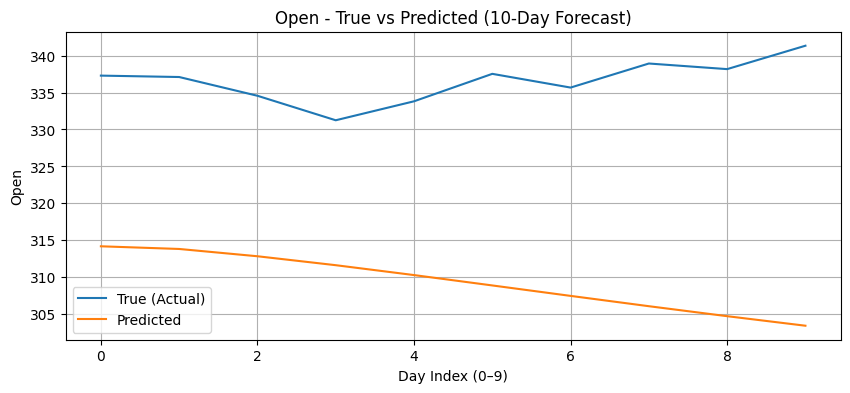

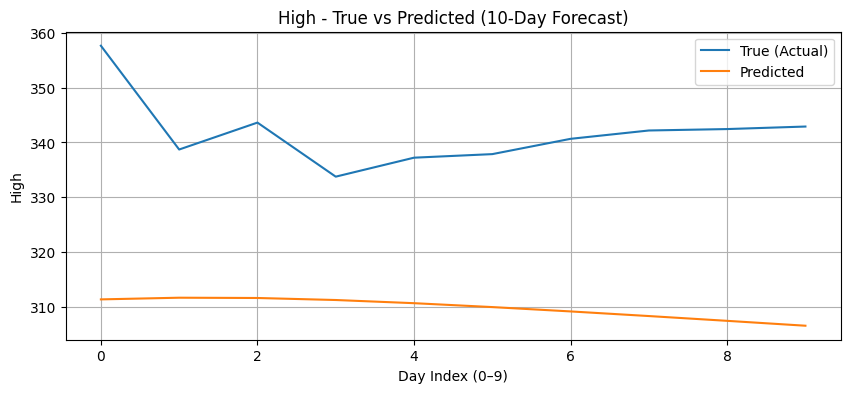

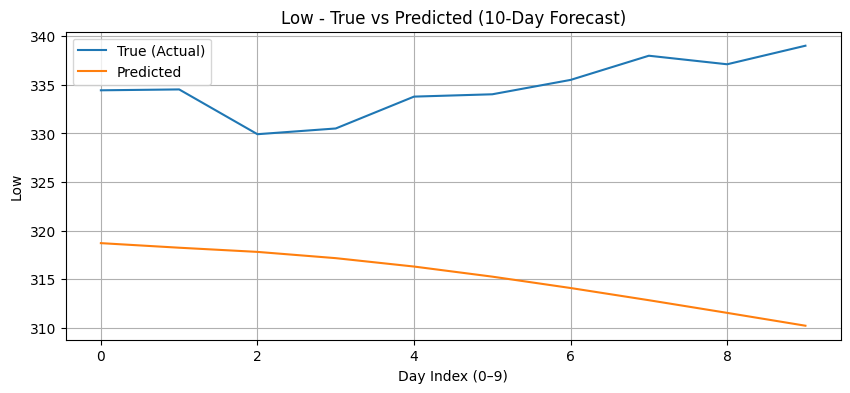

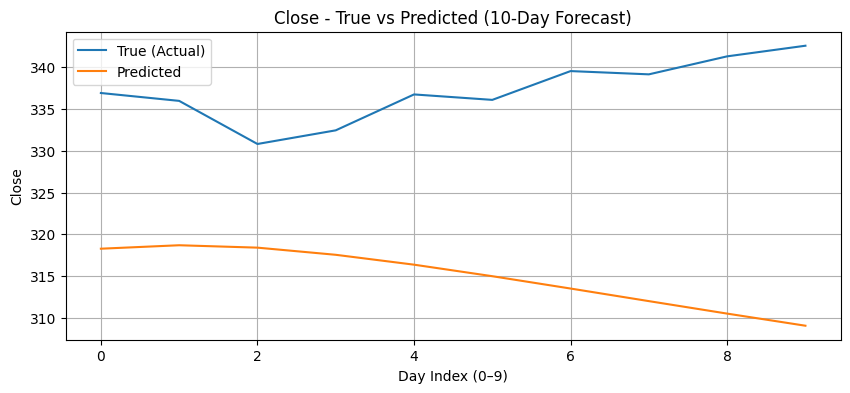

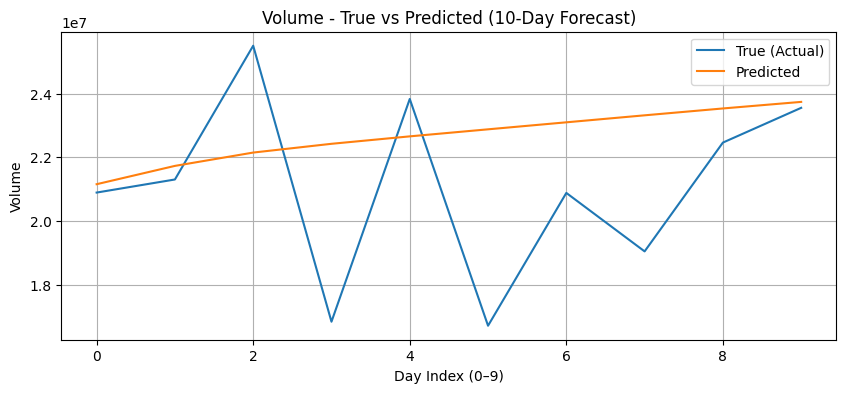

In [176]:
for i, col in enumerate(columns):
    plt.figure(figsize=(10,4))
    plt.plot(true_10[:, i], label="True (Actual)")
    plt.plot(future_LSTM_pred[:, i], label="Predicted")
    plt.title(f"{col} - True vs Predicted (10-Day Forecast)")
    plt.xlabel("Day Index (0–9)")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.show()



### Evaluation of the models

#### Evaluation of performance was based on MAE scores.


1.   LSTM performed best achieving lowest MAE scores acrosss four features(open, close, high, low)
2.   GRU was second best achieving lowest score for one feature(volume)
3.  SimpleRNN had the highest MAE across every feature, indicating largest prediction errors and weakest overall performance.

